# Easy way to use Kaggle datasets in Google Colab
Colab has free GPU usage but it can be a pain setting it up with Drive or managing files. Here's a sample script where you just need to paste in your username, API key, and competition name and it'll download and extract the files for you.<br><br>
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. Place this file in the location ~/.kaggle/kaggle.json<br>
<br>

The JSON file contains the following details:<br><br>
**{"username":"USERNAME","key":"API_KEY"}**<br><br>
Replace the USERNAME and API_KEY in the code below

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"ENTER_YOU_USERNAME","key":"ENTER_YOU_API_KEY"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c quora-insincere-questions-classification

 96% 53.0M/54.9M [00:01<00:00, 21.3MB/s]
100% 54.9M/54.9M [00:01<00:00, 45.5MB/s]
 57% 9.00M/15.8M [00:00<00:00, 15.2MB/s]
100% 15.8M/15.8M [00:00<00:00, 24.9MB/s]
100% 4.09M/4.09M [00:00<00:00, 11.1MB/s]

100% 5.95G/5.96G [02:15<00:00, 44.9MB/s]
100% 5.96G/5.96G [02:15<00:00, 47.2MB/s]


In [2]:
!ls

embeddings.zip	sample_submission.csv.zip  train.csv.zip
sample_data	test.csv.zip


In [3]:
!unzip embeddings.zip

Archive:  embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  


In [4]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [5]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [6]:
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 33kB/s 


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import string
import gc
from gensim.models import KeyedVectors
from keras.models import Model,Sequential
from keras.layers import Dense, Conv2D, Flatten,Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Activation


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

## Exploratory Data Analysis

 Data size and shape: 1.3 millions * 3 

In [9]:
data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Data is heavily imbalanced: 94% of texts are sincere and 6% are insincere.

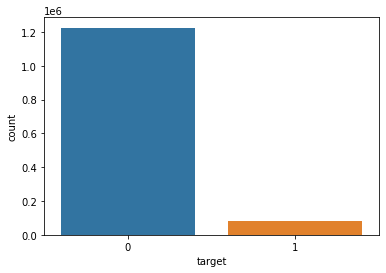

In [10]:
sns.countplot(x='target', data=data)

## Data Preprocessing

#### The following preprocessing is done:<br>
-Remove all punctuations<br>
-Remove all numbers<br>
-Remove stopwords<br>


In [0]:
def remove_punctuations(text):
    text = text.translate(str.maketrans("","", string.punctuation))
    text = text.translate(str.maketrans("","", '1234567890'))
    return text

In [0]:

data['question_text'] = data['question_text'].apply(lambda x: remove_punctuations(x))
test_data, data=data[1000000:], data[:1000000]

In [0]:
train, test = train_test_split(data, test_size=0.2, random_state=2018)
train_X = train["question_text"].fillna("_na_").values
test_X = test["question_text"].fillna("_na_").values
test_data_X = test_data["question_text"].fillna("_na_").values

We used Keras Embedding layer:

-Size of the vocabulary is set to 40000, which is equal to the maximum number of words in Text processing.

-Initialize weights to the embeddings matrix that we created by concatenating all 4 word embeddings.

-We set the length of input sequences to 70

In [0]:
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)
test_data_X = tokenizer.texts_to_sequences(test_data_X)

In [0]:
train_X = pad_sequences(train_X, maxlen=70)
test_X = pad_sequences(test_X, maxlen=70)
train_y = train['target'].values
test_y = test['target'].values
train_X=train_X.reshape(-1,70)
test_X=test_X.reshape(-1,70)
test_data_X = pad_sequences(test_data_X, maxlen=70)
test_data_y = test_data['target'].values
test_data_X=test_data_X.reshape(-1,70)

In [16]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Glove Embedding

In [17]:
EMBEDDING_FILE = './glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(40000, len(word_index))
embedding_matrix_1 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= 40000: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_1[i] = embedding_vector

del embeddings_index; gc.collect() 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


22

### Wiki News Embedding

In [18]:
EMBEDDING_FILE = './wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(40000, len(word_index))
embedding_matrix_2 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= 40000: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_2[i] = embedding_vector
        
del embeddings_index; gc.collect()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


22

### Paragrams Embedding

In [19]:
EMBEDDING_FILE = './paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(40000, len(word_index))
embedding_matrix_3 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= 40000: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_3[i] = embedding_vector

del embeddings_index; gc.collect()   

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


22

### Word2Vec Embedding

In [20]:
EMBEDDING_FILE = './GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
embeddings_index = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

word_index = tokenizer.word_index
nb_words = min(40000, len(word_index))
embedding_matrix_4 = (np.random.rand(nb_words, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= 40000: continue
    if word in embeddings_index:
        embedding_vector = embeddings_index.get_vector(word)
        embedding_matrix_4[i] = embedding_vector
        
del embeddings_index; gc.collect()    

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0

In [21]:
embedding_matrix = np.concatenate((embedding_matrix_1, embedding_matrix_2, embedding_matrix_3, embedding_matrix_4), axis=1)  
del embedding_matrix_1, embedding_matrix_2, embedding_matrix_3, embedding_matrix_4
gc.collect()
np.shape(embedding_matrix)

(40000, 1200)

In [0]:
#del model
#tf.keras.backend.clear_session()

In [0]:
model = Sequential()
model.add(Embedding(40000, embed_size * 4, weights=[embedding_matrix], input_length=70))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Conv1D(128, kernel_size=1, activation='relu', input_shape=(70, 32)))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.fit(train_X, train_y, validation_data=(test_X, test_y),batch_size=512, epochs=2, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 800000 samples, validate on 200000 samples
Epoch 1/2
800000/800000 [==============================] - 986s 1ms/step - loss: 0.1162 - accuracy: 0.9546 - val_loss: 0.1035 - val_accuracy: 0.9590
Epoch 2/2
800000/800000 [==============================] - 981s 1ms/step - loss: 0.0915 - accuracy: 0.9634 - val_loss: 0.1044 - val_accuracy: 0.9594


In [0]:
pred=model.predict(test_X)

In [27]:
from sklearn.metrics import f1_score
thresholds = []
for thresh in np.arange(0.1, 1, 0.01):
    thresh = np.round(thresh, 2)
    r= f1_score(test_y, (pred>thresh).astype(int))
    thresholds.append([thresh, r])
    print("F1 score at threshold {0} is {1}".format(thresh, r))

thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

F1 score at threshold 0.1 is 0.624075559119665
F1 score at threshold 0.11 is 0.6314350797266515
F1 score at threshold 0.12 is 0.6374709437470943
F1 score at threshold 0.13 is 0.6435062476334722
F1 score at threshold 0.14 is 0.6488689234718434
F1 score at threshold 0.15 is 0.6529693767733098
F1 score at threshold 0.16 is 0.6560174620498065
F1 score at threshold 0.17 is 0.6589812332439677
F1 score at threshold 0.18 is 0.6620206690236606
F1 score at threshold 0.19 is 0.6635237439779766
F1 score at threshold 0.2 is 0.6650874381662369
F1 score at threshold 0.21 is 0.6669487342218462
F1 score at threshold 0.22 is 0.6687595875994435
F1 score at threshold 0.23 is 0.6702054670855451
F1 score at threshold 0.24 is 0.6712913943553982
F1 score at threshold 0.25 is 0.6722447475119794
F1 score at threshold 0.26 is 0.6739487026543394
F1 score at threshold 0.27 is 0.6748540214729705
F1 score at threshold 0.28 is 0.673816314888762
F1 score at threshold 0.29 is 0.6730850370143071
F1 score at threshold 0.

In [0]:
threshold_values = np.array(thresholds)

Text(0, 0.5, 'F1 Score')

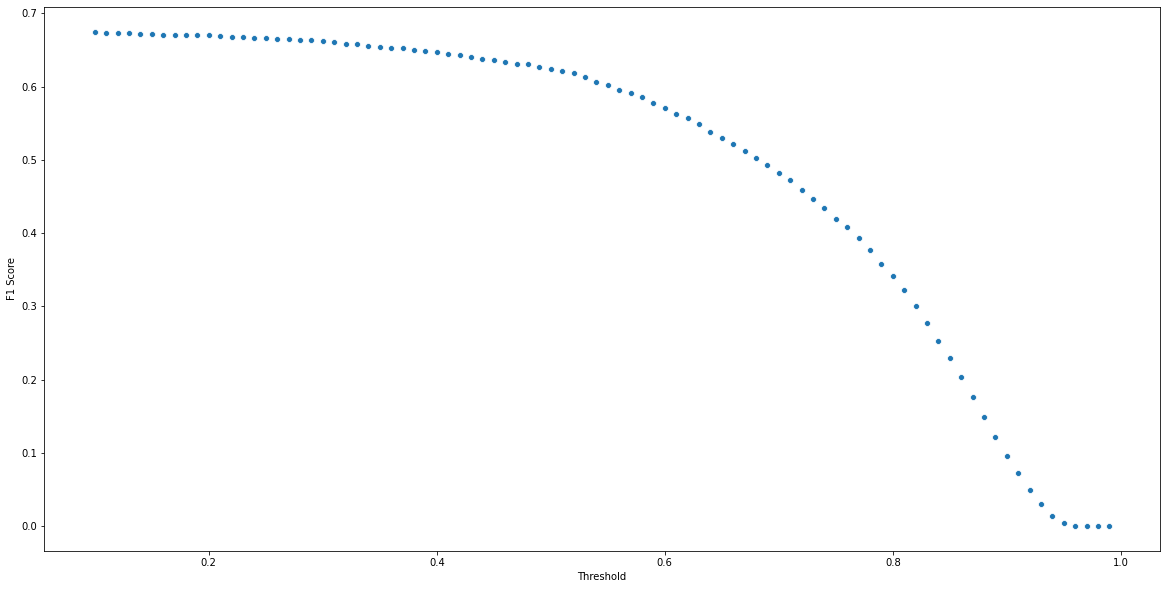

In [29]:
plt.figure(figsize=(20,10))
sns.scatterplot(np.arange(0.1, 1, 0.01),threshold_values[:,1])
plt.xlabel('Threshold')
plt.ylabel('F1 Score')

In [0]:
pred_values=[]
for i in pred:
  if i >best_thresh:
    pred_values.append(1)
  else:
    pred_values.append(0)

### Confusion Matrix

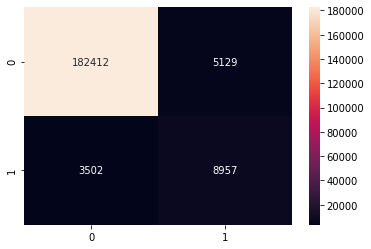

In [35]:
cf_matrix = confusion_matrix(test_y, pred_values)
sns.heatmap(cf_matrix, annot=True,fmt="d")